In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, cv
from xgboost import XGBClassifier, plot_tree
import seaborn as sns
import xgboost
import matplotlib.pyplot as plt
import time
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", 10000)
import warnings
warnings.filterwarnings('ignore')

Загрузим данные.

In [2]:
cols=['name','landmass','zone','area','population','language','religion','bars','stripes','colours',
      'red','green','blue','gold','white','black','orange','mainhue','circles','crosses','saltires',
      'quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright']

In [3]:
df=pd.read_csv('flag.data.txt',sep=',',header=None, names=cols)

In [4]:
df.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red


В данных есть следующие параметры:

   1. name	   Name of the country concerned
   2. landmass 1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania
   3. zone	   Geographic quadrant, based on Greenwich and the Equator 1=NE, 2=SE, 3=SW, 4=NW
   4. area	   in thousands of square km
   5. population	in round millions
   6. language 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others
   7. religion 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others
   8. bars     Number of vertical bars in the flag
   9. stripes  Number of horizontal stripes in the flag
   10. colours  Number of different colours in the flag
   11. red      0 if red absent, 1 if red present in the flag
   12. green    same for green
   13. blue     same for blue
   14. gold     same for gold (also yellow)
   15. white    same for white
   16. black    same for black
   17. orange   same for orange (also brown)
   18. mainhue  predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue)
   19. circles  Number of circles in the flag
   20. crosses  Number of (upright) crosses
   21. saltires Number of diagonal crosses
   22. quarters Number of quartered sections
   23. sunstars Number of sun or star symbols
   24. crescent 1 if a crescent moon symbol present, else 0
   25. triangle 1 if any triangles present, 0 otherwise
   26. icon     1 if an inanimate image present (e.g., a boat), otherwise 0
   27. animate  1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise
   28. text     1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise
   29. topleft  colour in the top-left corner (moving right to decide tie-breaks)
   30. botright colour in the bottom-left corner (moving left to decide tie-breaks)

Переведем название цвета в трех столбцах в числа:

In [5]:
le=LabelEncoder()
le.fit(df[['mainhue','topleft','botright']].stack())
df['mainhue'],df['topleft'],df['botright']=le.transform(df['mainhue']),le.transform(df['topleft']),le.transform(df['botright'])

In [6]:
df.describe()

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,3.572165,2.211340,700.046392,23.268041,5.340206,2.190722,0.453608,1.551546,3.463918,0.788660,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,4.252577,0.170103,0.149485,0.092784,0.149485,1.386598,0.056701,0.139175,0.252577,0.201031,0.082474,4.288660,4.000000
std,1.553018,1.308274,2170.927932,91.934085,3.496517,2.061167,1.038339,2.328005,1.300154,0.409315,0.500334,0.501187,0.500334,0.432631,0.444085,0.341556,2.207645,0.463075,0.385387,0.290879,0.435860,4.396186,0.231869,0.347025,0.435615,0.401808,0.275798,2.457762,2.292136
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.500000,4.000000
75%,5.000000,4.000000,471.250000,14.000000,9.000000,4.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,0.000000,0.000000,6.000000,6.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,7.000000,5.000000,14.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.000000,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000


In [7]:
df.religion.value_counts()

1    60
0    40
2    36
5    27
6    15
3     8
7     4
4     4
Name: religion, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    int64 
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

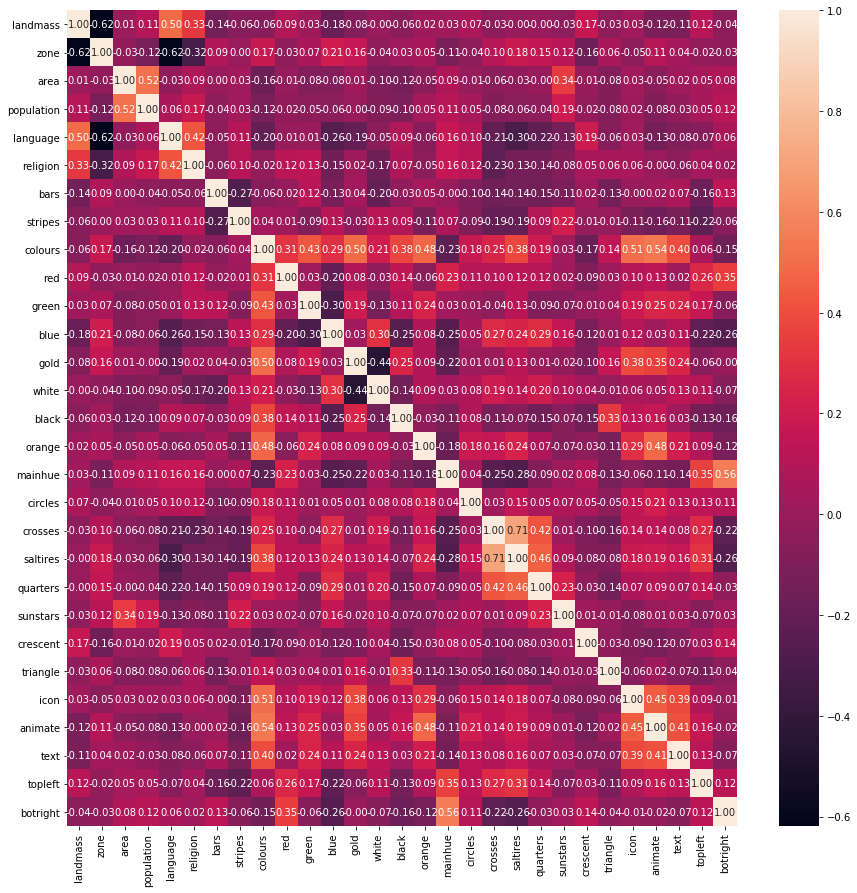

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,fmt='.2f',ax=ax)
plt.show()

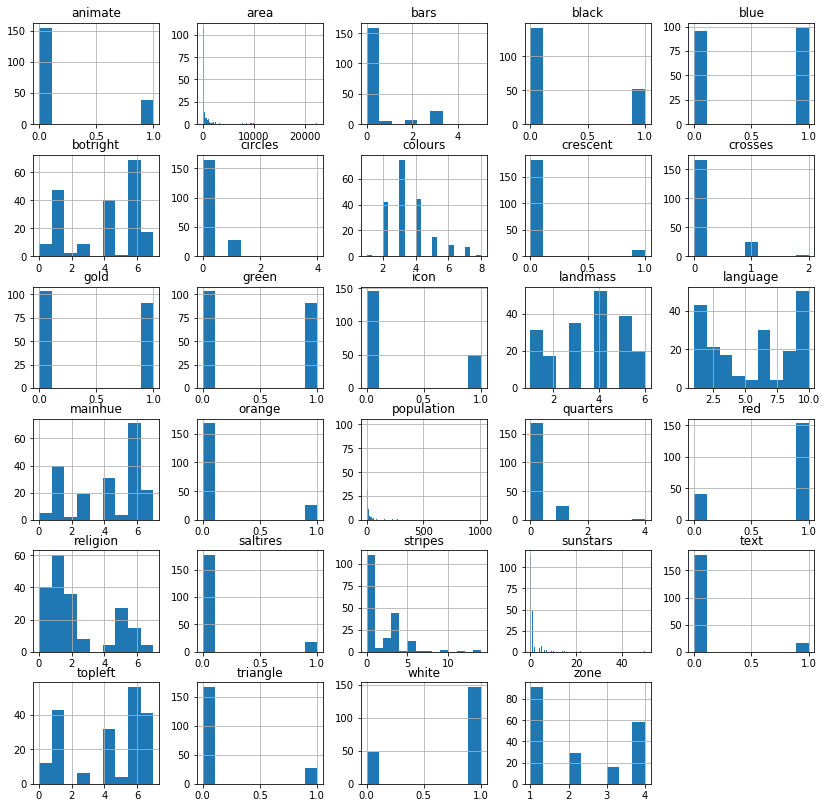

In [10]:
df.hist(figsize=(14,14),bins='auto')
plt.show()

Посмотим, какие параметры отличаются в разных религиях:

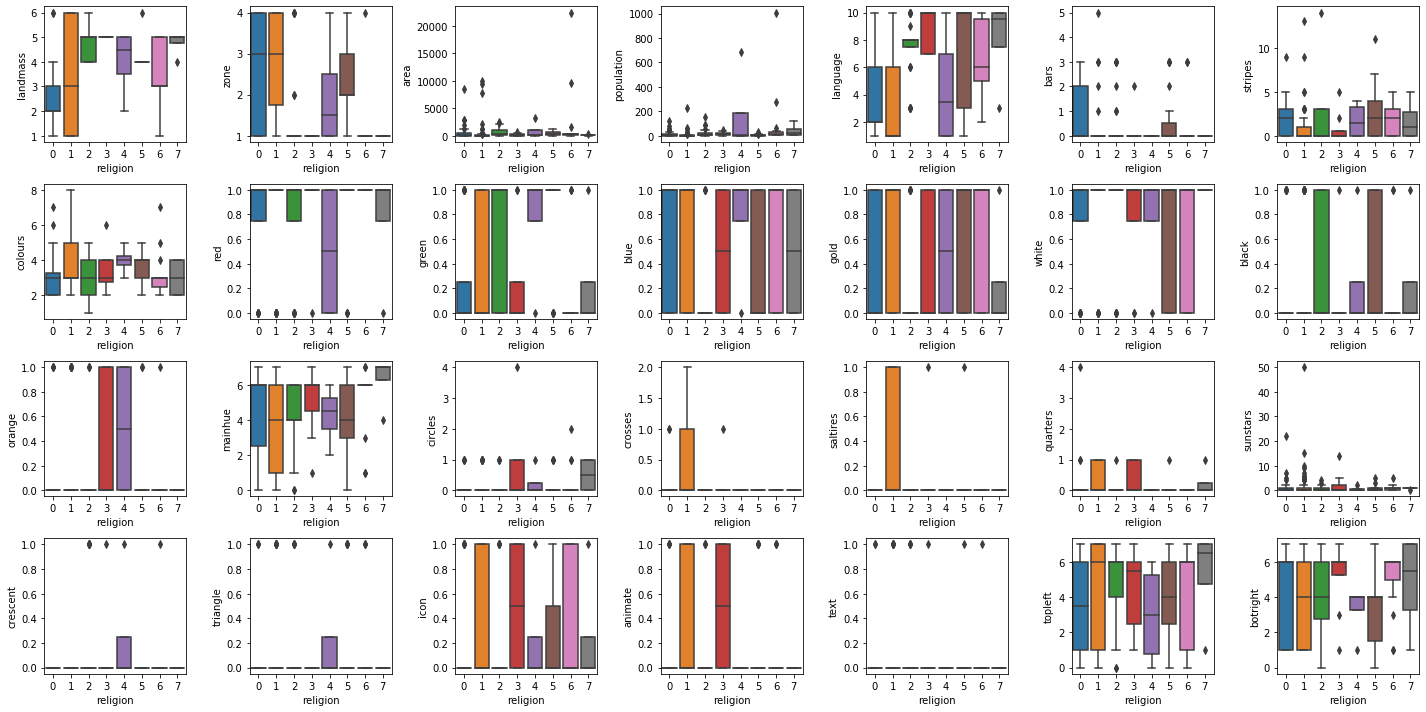

In [11]:
cor_col=['landmass','zone','area','population','language','bars','stripes','colours',
         'red','green','blue','gold','white','black','orange','mainhue','circles','crosses','saltires',
         'quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright']
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(20, 10))
for i, feat in enumerate(cor_col): 
    ax = axes[int(i/7),i%7] 
    sns.boxplot(x='religion', y=feat, data=df, ax=ax) 
    ax.set_xlabel('religion') 
    ax.set_ylabel(feat) 
fig.tight_layout()

Разделим данные для тех параметров, которые отличаются.

In [12]:
X_train,X_test,y_train,y_test=train_test_split(df[['landmass','zone','area','population','language','bars',
                                                   'stripes','colours','red','green','blue','gold','white',
                                                   'black','orange','mainhue','circles','crosses','saltires',
                                                   'quarters','sunstars','crescent','triangle','icon','animate',
                                                   'text','topleft','botright']],df['religion'])

Различные модели:

1.

In [13]:
param = {'penalty':['l2','l1'],'C': [0.001,0.01,0.1,1],'solver':['saga'],'max_iter':[5000,8000]}
grid = GridSearchCV(LogisticRegression(multi_class='multinomial'), param_grid = param, scoring = 'accuracy', cv=3)
grid.fit(X_train,y_train)
res=pd.DataFrame(grid.cv_results_)
res.sort_values('mean_test_score',ascending=False)[['params','mean_test_score']][:6]

,params,mean_test_score
5,"{'C': 0.01, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga'}",0.310516
7,"{'C': 0.01, 'max_iter': 8000, 'penalty': 'l1', 'solver': 'saga'}",0.310516
9,"{'C': 0.1, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga'}",0.310374
11,"{'C': 0.1, 'max_iter': 8000, 'penalty': 'l1', 'solver': 'saga'}",0.310374
0,"{'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}",0.303430
2,"{'C': 0.001, 'max_iter': 8000, 'penalty': 'l2', 'solver': 'saga'}",0.303430


In [14]:
y_pred=grid.best_estimator_.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred),
      '\nf1-score',f1_score(y_test,y_pred,average='weighted'),
      '\nprecision',precision_score(y_test,y_pred,average='weighted'),
      '\nrecall',recall_score(y_test,y_pred,average='weighted'))

accuracy 0.30612244897959184 
f1-score 0.18555114353433685 
precision 0.13432282003710574 
recall 0.30612244897959184


2.

In [15]:
model2=GaussianNB()
model2.fit(X_train,y_train)
y_pred=model2.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred),
      '\nf1-score',f1_score(y_test,y_pred,average='weighted'),
      '\nprecision',precision_score(y_test,y_pred,average='weighted'),
      '\nrecall',recall_score(y_test,y_pred,average='weighted'))

accuracy 0.3469387755102041 
f1-score 0.42761475002197374 
precision 0.6270165208940719 
recall 0.3469387755102041


3.

In [16]:
param3 = {'n_neighbors':[5,10,15],'leaf_size': [30,40,50], 'p':[1,2]}
grid3 = GridSearchCV(KNeighborsClassifier(), param_grid = param3, scoring = 'accuracy', cv=3)
grid3.fit(X_train,y_train)
res3=pd.DataFrame(grid3.cv_results_)
res3.sort_values('mean_test_score',ascending=False)[['params','mean_test_score']][:6]

,params,mean_test_score
12,"{'leaf_size': 50, 'n_neighbors': 5, 'p': 1}",0.414399
0,"{'leaf_size': 30, 'n_neighbors': 5, 'p': 1}",0.407455
6,"{'leaf_size': 40, 'n_neighbors': 5, 'p': 1}",0.407455
1,"{'leaf_size': 30, 'n_neighbors': 5, 'p': 2}",0.393991
7,"{'leaf_size': 40, 'n_neighbors': 5, 'p': 2}",0.393991
13,"{'leaf_size': 50, 'n_neighbors': 5, 'p': 2}",0.387188


In [17]:
y_pred=grid3.best_estimator_.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred),
      '\nf1-score',f1_score(y_test,y_pred,average='weighted'),
      '\nprecision',precision_score(y_test,y_pred,average='weighted'),
      '\nrecall',recall_score(y_test,y_pred,average='weighted'))

accuracy 0.42857142857142855 
f1-score 0.4344388071096145 
precision 0.47217068645640076 
recall 0.42857142857142855


4.

In [18]:
param4 = {'n_estimators':[5,10,15],'max_features':['sqrt','log2','auto'],'bootstrap':[True,False]}
grid4 = GridSearchCV(RandomForestClassifier(), param_grid = param4, scoring = 'accuracy', cv=3, iid=True)
grid4.fit(X_train,y_train)
res4=pd.DataFrame(grid4.cv_results_)
res4.sort_values('mean_test_score',ascending=False)[['params','mean_test_score']][:6]

,params,mean_test_score
2,"{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 15}",0.641379
11,"{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 15}",0.641379
17,"{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 15}",0.634483
16,"{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 10}",0.627586
8,"{'bootstrap': True, 'max_features': 'auto', 'n_estimators': 15}",0.613793
5,"{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 15}",0.613793


In [19]:
y_pred=grid4.best_estimator_.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred),
      '\nf1-score',f1_score(y_test,y_pred,average='weighted'),
      '\nprecision',precision_score(y_test,y_pred,average='weighted'),
      '\nrecall',recall_score(y_test,y_pred,average='weighted'))

accuracy 0.7142857142857143 
f1-score 0.6979868310960748 
precision 0.6882086167800453 
recall 0.7142857142857143


In [20]:
confusion_matrix(y_test,y_pred)

array([[ 8,  1,  0,  0,  0,  0,  1,  0],
       [ 1, 13,  2,  0,  0,  0,  0,  0],
       [ 1,  2,  9,  0,  0,  1,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  3,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1]])

5.

In [21]:
def randomized_cv(model, param_grid, x_train, y_train, x_test, y_test):
    grid_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='accuracy',iid=True)
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    y_pred=grid_search.best_estimator_.predict(x_test)
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    print('model {} best accuracy score on test is {}'.format(model.__class__.__name__, accuracy_score(y_test,y_pred)))
    return grid_search.best_estimator_, accuracy_score(y_test,y_pred)

In [22]:
param_gridC = {'iterations': [100,500],'learning_rate': [0.01, 0.05,0.2],
              'random_strength':[0.1,0.01],'depth':[4,8]}
cbc = randomized_cv(CatBoostClassifier(loss_function='MultiClass',eval_metric='Accuracy',logging_level='Silent'),
                    param_gridC, X_train, y_train, X_test, y_test)

model CatBoostClassifier best accuracy score is 0.6551724137931034
time for training is 500.48173093795776 seconds
model CatBoostClassifier best accuracy score on test is 0.6938775510204082


In [23]:
cbc[0].get_params()

{'iterations': 500,
 'learning_rate': 0.2,
 'depth': 4,
 'loss_function': 'MultiClass',
 'logging_level': 'Silent',
 'random_strength': 0.01,
 'eval_metric': 'Accuracy'}

In [24]:
cbc=CatBoostClassifier(loss_function='MultiClass',eval_metric='Accuracy',
                       logging_level='Silent',random_strength= 0.1,learning_rate= 0.01,
                      iterations=500,depth=8)
cbc.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)
print(cbc.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Accuracy': 0.903448275862069, 'MultiClass': 0.5955125051547367}, 'validation': {'Accuracy': 0.7346938775510204, 'MultiClass': 1.0372738139989237}}


In [25]:
y_pred=np.hstack(cbc.predict(X_test))
print('accuracy',accuracy_score(y_test,y_pred),
      '\nf1-score',f1_score(y_test,y_pred,average='weighted'),
      '\nprecision',precision_score(y_test,y_pred,average='weighted'),
      '\nrecall',recall_score(y_test,y_pred,average='weighted'))

accuracy 0.7346938775510204 
f1-score 0.712325864717411 
precision 0.710236475542598 
recall 0.7346938775510204


In [26]:
confusion_matrix(y_test,y_pred)

array([[ 8,  0,  2,  0,  0,  0,  0,  0],
       [ 1, 13,  1,  0,  0,  1,  0,  0],
       [ 0,  0, 11,  0,  0,  2,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  4,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0]])

Какие же параметры наиболее значимы?

In [27]:
pd.DataFrame(cbc.get_feature_importance(),
             index=X_train.columns,columns=['Importance']).sort_values('Importance',ascending=False)

,Importance
landmass,41.573595
language,31.470240
zone,11.371618
population,6.267456
area,2.593557
crosses,2.066122
green,0.785372
bars,0.764195
colours,0.633005
mainhue,0.497049
